In [1]:
# import the propert libraries and load the dataset for modeling

import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import copy
import random as rand

data = pd.read_csv("c:\\Users\\markm\\Desktop\\CAPSTONE\\capstone\\data\\external\\watson_healthcare_modified.csv")

c:\Users\markm\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# take a look at the first 5 rows of data for familiarization
data.head()


,EmployeeID,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,...,RelationshipSatisfaction,StandardHours,Shift,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,1313919,41,No,Travel_Rarely,1102,Cardiology,1,2,Life Sciences,1,...,1,80,0,8,0,1,6,4,0,5
1,1200302,49,No,Travel_Frequently,279,Maternity,8,1,Life Sciences,1,...,4,80,1,10,3,3,10,7,1,7
2,1060315,37,Yes,Travel_Rarely,1373,Maternity,2,2,Other,1,...,2,80,0,7,3,3,0,0,0,0
3,1272912,33,No,Travel_Frequently,1392,Maternity,3,4,Life Sciences,1,...,3,80,0,8,3,3,8,7,3,0
4,1414939,27,No,Travel_Rarely,591,Maternity,2,1,Medical,1,...,4,80,1,6,3,3,2,2,2,2


In [3]:
# use the .info() call to see the total number of rows, columns, and datatypes of columns.
### Open the full output in a text editor if size limit is reached
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1676 entries, 0 to 1675
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   EmployeeID                1676 non-null   int64 
 1   Age                       1676 non-null   int64 
 2   Attrition                 1676 non-null   object
 3   BusinessTravel            1676 non-null   object
 4   DailyRate                 1676 non-null   int64 
 5   Department                1676 non-null   object
 6   DistanceFromHome          1676 non-null   int64 
 7   Education                 1676 non-null   int64 
 8   EducationField            1676 non-null   object
 9   EmployeeCount             1676 non-null   int64 
 10  EnvironmentSatisfaction   1676 non-null   int64 
 11  Gender                    1676 non-null   object
 12  HourlyRate                1676 non-null   int64 
 13  JobInvolvement            1676 non-null   int64 
 14  JobLevel                

In [4]:
# let's slice the data into x and y, for building predictive models
y = data['Attrition']
x = data.drop(columns=['EmployeeID','Attrition'])

In [5]:
# look at the shape of the x and y dataframes to ensure they matchup
print(x.shape)
print(y.shape)

(1676, 33)
(1676,)


In [6]:
# look at the target variable to see if we have an imbalanced dataset
y.value_counts()

No     1477
Yes     199
Name: Attrition, dtype: int64

#### In this case, we do have an imbalanced dataset because there are ~88% 'No's and ~12% 'Yes's 

In [7]:
# Change the target variable to quantitative for modeling purposes
y.replace('No', 0, inplace=True)
y.replace('Yes', 1, inplace = True)

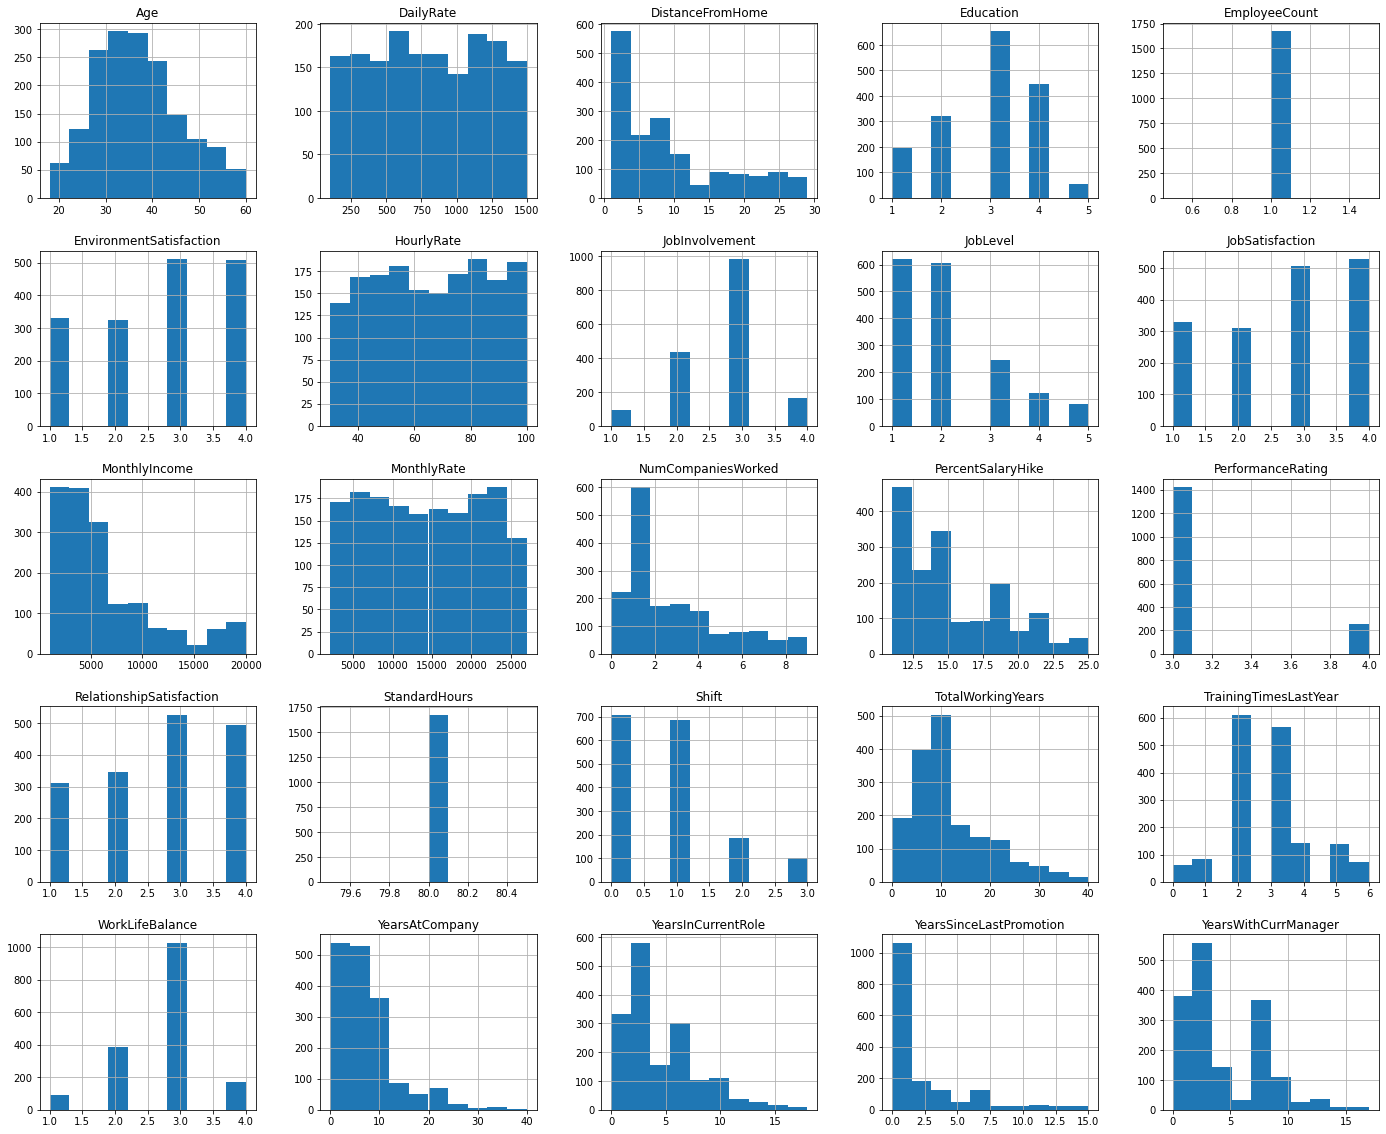

In [8]:
# plot histograms of each numerical value
# This will look at variances within each individual feature, allowing us to eliminate features without variance
import matplotlib.pyplot as plt

#fig = plt.figure(figsize = (20,12))
x.hist(figsize = (24,20))

plt.show()


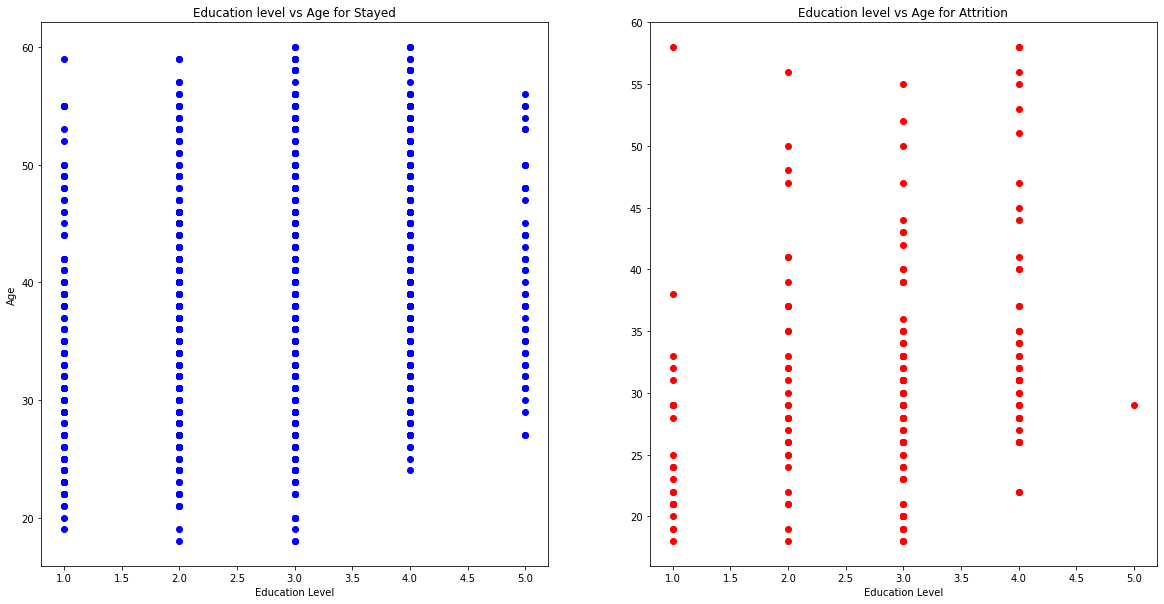

In [9]:
# now let's look at some of the columns with the y value as well
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (20,10))


ax[0].scatter(data.Education[data.Attrition==0], data.Age[data.Attrition==0], c='b', label = 'stayed')


ax[1].scatter(data.Education[data.Attrition==1], data.Age[data.Attrition==1], c='r', label = 'attrited')


ax[0].set_xlabel('Education Level')
ax[0].set_ylabel('Age')
ax[1].set_xlabel('Education Level')

ax[0].set_title('Education level vs Age for Stayed', loc='center')
ax[1].set_title('Education level vs Age for Attrition', loc='center')

plt.show()

In [10]:
# Check the Over18 column to see if there is variation in this feature
x.Over18.unique()

array(['Y'], dtype=object)

In [11]:
# based off of this analysis, let's drop 'EmployeeCount' & 'StandardHours' because there is no variance in these features
x = x.drop(columns=['Over18','EmployeeCount','StandardHours'], axis=1)

## Now that we have initially analyzed the data, let's pass this data into 'LazyClassifier' to figure out which models could work best with the model

In [12]:
# import the necessary modules 
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

c:\Users\markm\anaconda3\lib\site-packages\dask\dataframe\utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
c:\Users\markm\anaconda3\lib\site-packages\dask\dataframe\utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
c:\Users\markm\anaconda3\lib\site-packages\dask\dataframe\utils.py:367: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


In [13]:
# split the x and y dataframes then call the LazyClassifier and display the results
x_train_l, x_test_l, y_train_l, y_test_l = train_test_split(x,y, test_size =0.2, random_state=42)

clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

models, predictions = clf.fit(x_train_l,x_test_l,y_train_l,y_test_l)

models

100%|██████████| 29/29 [00:02<00:00, 10.44it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
Perceptron,0.88,0.79,0.79,0.89,0.02
LinearSVC,0.92,0.79,0.79,0.92,0.09
LogisticRegression,0.92,0.78,0.78,0.92,0.05
PassiveAggressiveClassifier,0.89,0.78,0.78,0.89,0.03
AdaBoostClassifier,0.93,0.77,0.77,0.92,0.23
SGDClassifier,0.91,0.75,0.75,0.90,0.03
NearestCentroid,0.71,0.74,0.74,0.75,0.11
CalibratedClassifierCV,0.92,0.74,0.74,0.91,0.17
LinearDiscriminantAnalysis,0.91,0.73,0.73,0.90,0.11


In [14]:
# look at the datatypes that are not quantitative
data.select_dtypes(include=['object']).head(2)

,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,Over18,OverTime
0,Travel_Rarely,Cardiology,Life Sciences,Female,Nurse,Single,Y,Yes
1,Travel_Frequently,Maternity,Life Sciences,Male,Other,Married,Y,No


In [15]:
# Pint the unique values of each 'object' feature
print("Department: ", data.Department.unique())
print("Business Travel: ",data.BusinessTravel.unique())
print("EducationField: ",data.EducationField.unique())
print("Gender: ",data.Gender.unique())
print("JobRole: ",data.JobRole.unique())
print("MaritalStatus	: ",data.MaritalStatus.unique())
#print("Over18: ",data.Over18.unique())
print("OverTime: ", data.OverTime.unique())


Department:  ['Cardiology' 'Maternity' 'Neurology']
Business Travel:  ['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']
EducationField:  ['Life Sciences' 'Other' 'Medical' 'Marketing' 'Technical Degree'
 'Human Resources']
Gender:  ['Female' 'Male']
JobRole:  ['Nurse' 'Other' 'Therapist' 'Administrative' 'Admin']
MaritalStatus	:  ['Single' 'Married' 'Divorced']
OverTime:  ['Yes' 'No']


### Analysis
- I am going to encode these variables using 'get_dummies' for modeling purposes, so that all pertinent variables are quantitative

In [16]:
# example of the get_dummies call, including prefix for understanding of new variables
pd.get_dummies(x['Department'], prefix='Department')

,Department_Cardiology,Department_Maternity,Department_Neurology
0,1,0,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0
...,...,...,...
1671,0,0,1
1672,1,0,0
1673,0,1,0
1674,0,0,1


In [17]:
### function for converting the 'object' type features to quantitative features
def convert_numeric(data):

    # Get dummy variables for 'object' columns
    data_ohe = data
    categorical_columns = data.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        col_ohe = pd.get_dummies(data[col], prefix=col)
        data_ohe = pd.concat((data_ohe, col_ohe), axis=1).drop(col, axis=1)

    return data_ohe

In [18]:
# convert the data and show the first two rows of the new dataframe
x = convert_numeric(x)

x.head(2)

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Admin,JobRole_Administrative,JobRole_Nurse,JobRole_Other,JobRole_Therapist,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,41,1102,1,2,2,94,3,2,4,5993,...,0,0,1,0,0,0,0,1,0,1
1,49,279,8,1,3,61,2,2,2,5130,...,0,0,0,1,0,0,1,0,1,0


In [19]:
# look at the names of the new columns
x.columns

Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel',
       'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'Shift', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Frequently',
       'BusinessTravel_Travel_Rarely', 'Department_Cardiology',
       'Department_Maternity', 'Department_Neurology',
       'EducationField_Human Resources', 'EducationField_Life Sciences',
       'EducationField_Marketing', 'EducationField_Medical',
       'EducationField_Other', 'EducationField_Technical Degree',
       'Gender_Female', 'Gender_Male', 'JobRole_Admin',
       'JobRole_Administrative', 'JobRole_Nurse', 'JobRole_Other',
     

## First Method : Logistic Regression

### Base model with unbalanced data (before using SMOTE)

In [20]:
# create the logistic regression  model
from sklearn.linear_model import LogisticRegression

# create the base instance of the model for exploration, setting the max_iterations high so the model can reach convergence
log_r = LogisticRegression(max_iter=100000)


In [59]:
# split the data after numeric conversion
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size =0.2, random_state=42)

# fit the data on the training data
log_r.fit(x_train, y_train)

LogisticRegression(max_iter=100000)

In [22]:
# generate the predictions and show the overall 'accuracy' of the model 
predictions = log_r.predict(x_test)
score = log_r.score(x_test, y_test)
print(score)

0.9077380952380952


### For better understanding of model performance, let's use a confusion matrix to show more in depth metrics

In [23]:
# import the necessary modules for creating the confusion matric
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import classification_report

cm = metrics.confusion_matrix(y_test, predictions)

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       289
           1       0.74      0.53      0.62        47

    accuracy                           0.91       336
   macro avg       0.83      0.75      0.78       336
weighted avg       0.90      0.91      0.90       336



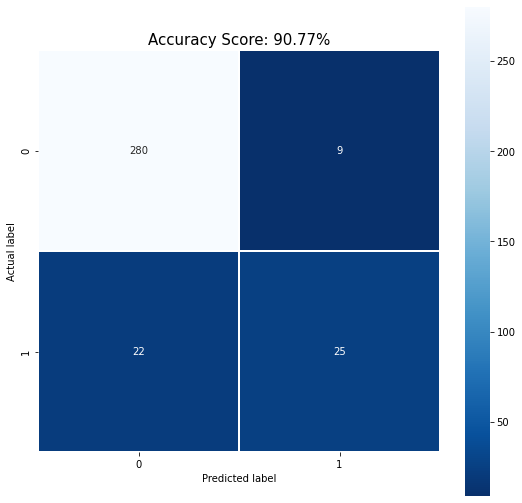

In [24]:
# plot the confusion matrix and print the report
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {:.2f}%'.format(score*100, {"3f"})
plt.title(all_sample_title, size = 15)

print(classification_report(y_test,predictions))

plt.show()

### Let's try running the base model after balancing the data set to see if we have improvement

In [60]:
# # pip install imbalanced-learn
# import imblearn

from imblearn.over_sampling import SMOTE

# transform the dataset
oversample = SMOTE()
x_bal_train, y_bal_train = oversample.fit_resample(x_train, y_train)

In [26]:
# look at the new re_sampled data, showcasing balance in the training data
y_bal_train.value_counts()

0    1188
1    1188
Name: Attrition, dtype: int64

In [27]:

# fit the data on the balanced training data
log_r.fit(x_bal_train, y_bal_train)

LogisticRegression(max_iter=100000)

In [28]:
# generate predictions for the model trained on 'balanced' training data and show accuracy
predictions = log_r.predict(x_test)
logr_score = log_r.score(x_test, y_test)
print(logr_score)

0.8988095238095238


              precision    recall  f1-score   support

           0       0.92      0.96      0.94       289
           1       0.69      0.51      0.59        47

    accuracy                           0.90       336
   macro avg       0.80      0.74      0.76       336
weighted avg       0.89      0.90      0.89       336



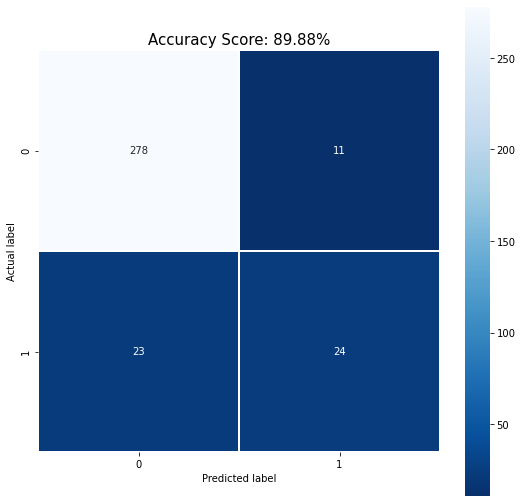

In [29]:
# plot the confusion matrix of this 'balanced' log_r model and print the report for analysis
cm = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {:.2f}%'.format(logr_score*100, {"3f"})
plt.title(all_sample_title, size = 15)

print(classification_report(y_test,predictions))

#### Overall, the balancing of the data actually worsened our results by a little bit. For this reason, I will choose not to use SMOTE for the log_r model
- Also, using SMOTE could cause explainability issues as it is a more complex technique. Therefore, keeping the data 'unbalanced' will allow for easier understanding of the model 

## Second Model: XGBoost Classifier

In [30]:
# Now let's create and test our XGBoost Classifier model
import xgboost as xgb

# create model instances for both 'unbalanced' and 'balanced' training data
xgb_cl = xgb.XGBClassifier()
xgb_bal_cl = xgb.XGBClassifier()

In [31]:
# split the data after numeric conversion
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size =0.2, random_state=42)

# transform the dataset using SMOTE 
oversample = SMOTE()
x_bal_train, y_bal_train = oversample.fit_resample(x_train, y_train)

# Fit the unbalanced model
xgb_cl.fit(x_train, y_train)

# Fit the 'balanced' model
xgb_bal_cl.fit(x_bal_train, y_bal_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [32]:
# Predict on the 'unbalanced' model and show the overall accuracy
preds = xgb_cl.predict(x_test)

xgb_score = xgb_cl.score(x_test, y_test)
print(xgb_score)

0.9107142857142857


              precision    recall  f1-score   support

           0       0.91      0.99      0.95       289
           1       0.87      0.43      0.57        47

    accuracy                           0.91       336
   macro avg       0.89      0.71      0.76       336
weighted avg       0.91      0.91      0.90       336



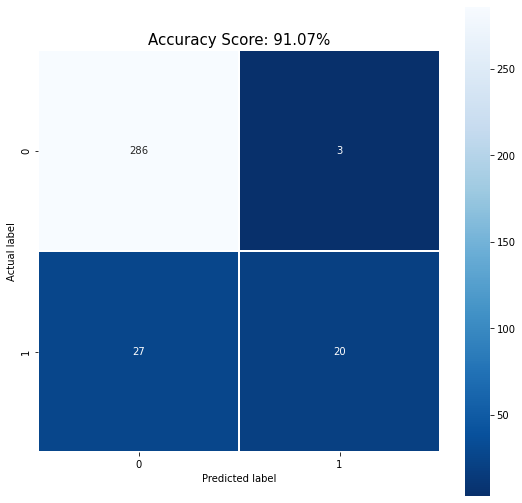

In [33]:
cm = metrics.confusion_matrix(y_test, preds)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {:.2f}%'.format(xgb_score*100, {"3f"})
plt.title(all_sample_title, size = 15)

print(classification_report(y_test,preds))

In [34]:
# Predict on the 'balanced' model and show the overall accuracy
preds_bal = xgb_bal_cl.predict(x_test)

xgb_bal_score = xgb_bal_cl.score(x_test, y_test)
print(xgb_bal_score)

0.9166666666666666


              precision    recall  f1-score   support

           0       0.93      0.98      0.95       289
           1       0.83      0.51      0.63        47

    accuracy                           0.92       336
   macro avg       0.88      0.75      0.79       336
weighted avg       0.91      0.92      0.91       336



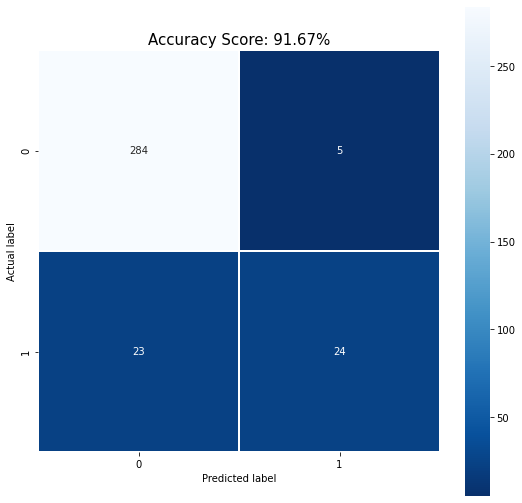

In [35]:
cm = metrics.confusion_matrix(y_test, preds_bal)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {:.2f}%'.format(xgb_bal_score*100, {"3f"})
plt.title(all_sample_title, size = 15)

print(classification_report(y_test,preds_bal))

#### For XGBOOST, I will use the 'balanced' model. Even though it's overall accuracy was slightly worse, It did have a lower false-negative number. This number is what I am trying to minimize (without having too much of a tradeoff in model performance), so the improvement in this category [Bottom left number where we predicted 'No' and it was actually 'Yes'] is worth the 1% loss in accuracy

## THIRD MODEL : Neural Network
- I will not be using this model in the actual 'run.py'. This attempt is just for fun to see if a 'simple' neural network could outperform logisitic regression / xgboost classifier

- Even though I kept this network very simple, it did take a lot longer to train than the other models. Adding in parameters / better architecture to try to improve performance would only add to the computation time to train the network, so I am not going to be pursuin this model type to solve the attrition problem

In [36]:
#define custom loss for unbalanced data set using inverse weights

class CrossEntropyLoss(tf.keras.losses.Loss):

    def __init__(self):

        super().__init__(name='CrossEntropyLoss')

 

    def call(self, y_true, y_pred):

        """

        Cross entropy loss adjusted for class imabalance and one-hot encoding sparsity

        """

        y_true = tf.cast(y_true, dtype=tf.float64)

        y_pred = tf.cast(y_pred, dtype=tf.float64)

 

        epsilon = tf.constant(1e-7, dtype=tf.float64) #avoid nans

        loss = (tf.math.log(y_pred+epsilon)*y_true + tf.math.log((1-y_pred)+epsilon) * (1-y_true))*-1.0

        tf.debugging.assert_all_finite(loss, 'There are nan values')

        return tf.reduce_sum(tf.reduce_mean(loss, axis = 0))

 

class ClassImbalanceSparsityAdjustedCEL(tf.keras.losses.Loss):

    def __init__(self, inverse_class_weights):

        """

        Initialization of inverse class weights

        """

        super().__init__(name='ClassImbalanceSparsityAdjustedCEL')

        self.inverse_class_weights = inverse_class_weights

 

    def call(self, y_true, y_pred):

        """

        Cross entropy loss adjusted for class imabalance and one-hot encoding sparsity

        """

        P = tf.reduce_sum(y_true)

        N = -1 * tf.reduce_sum(y_true - 1)

 

        beta_P = tf.cast((P + N) / P, dtype=tf.float64)

        beta_N = tf.cast((P + N) / N, dtype=tf.float64)

 

        y_true = tf.cast(y_true, dtype=tf.float64)

        y_pred = tf.cast(y_pred, dtype=tf.float64)

 

        epsilon = tf.constant(1e-7, dtype=tf.float64) #avoid nans

        loss = (beta_P*tf.math.log(y_pred+epsilon)*y_true + beta_N*tf.math.log((1-y_pred)+epsilon) * (1-y_true))*-1.0

        tf.debugging.assert_all_finite(loss, 'There are nan values')

        return tf.reduce_sum(tf.reduce_mean(loss, axis = 0)*self.inverse_class_weights)

 



In [55]:
# function to plot accuracy and loss

import matplotlib.pyplot as plt
%matplotlib inline

def plot_acc_loss(history):
    
    plt.figure(1)  

    # summarize history for accuracy  

    plt.subplot(211)  
    plt.plot(history.history[list(history.history.keys())[1]])  
    plt.plot(history.history[list(history.history.keys())[3]])  
    plt.title('False Negative Graph')  
    plt.ylabel('# False Negatives')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'val'], loc='upper left')  

    # summarize history for loss  

    plt.subplot(212)  
    plt.plot(history.history[list(history.history.keys())[0]])  
    plt.plot(history.history[list(history.history.keys())[2]])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'val'], loc='upper left')

    plt.tight_layout()
    plt.show() 
    
    return

## Begin with Unbalanced Data

****** With Normalization Layer *******
Residual True
Epoch 1/50
42/42 - 2s - loss: 0.7391 - false_negatives_3: 185.0000 - val_loss: 0.3994 - val_false_negatives_3: 47.0000 - 2s/epoch - 48ms/step
Epoch 2/50
42/42 - 0s - loss: 0.3364 - false_negatives_3: 152.0000 - val_loss: 0.4043 - val_false_negatives_3: 47.0000 - 148ms/epoch - 4ms/step
Epoch 3/50
42/42 - 0s - loss: 0.3324 - false_negatives_3: 151.0000 - val_loss: 0.4068 - val_false_negatives_3: 47.0000 - 141ms/epoch - 3ms/step
Epoch 4/50
42/42 - 0s - loss: 0.3285 - false_negatives_3: 152.0000 - val_loss: 0.4056 - val_false_negatives_3: 47.0000 - 130ms/epoch - 3ms/step
Epoch 5/50
42/42 - 0s - loss: 0.3331 - false_negatives_3: 152.0000 - val_loss: 0.4008 - val_false_negatives_3: 47.0000 - 130ms/epoch - 3ms/step
Epoch 6/50
42/42 - 0s - loss: 0.3320 - false_negatives_3: 150.0000 - val_loss: 0.3865 - val_false_negatives_3: 47.0000 - 143ms/epoch - 3ms/step
Epoch 7/50
42/42 - 0s - loss: 0.3279 - false_negatives_3: 151.0000 - val_loss: 0.409

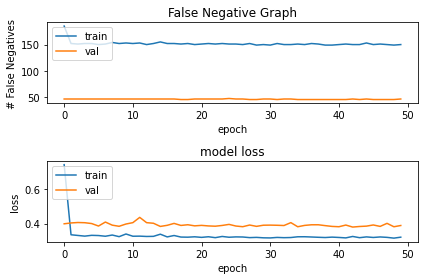

[0.3896336257457733, 47.0]


In [61]:


#x_train, x_val, y_train, y_val = train_test_split(x,y, test_size =0.2, random_state=42)

# set the paramters for the network
batch_size = 32
epochs = 50
n_hidden_units = 128
n_hidden_layers = 6

# engineer the learning rate so that it works with floats as randrange only works with ints
lr = .002

# way to one hot encode the target variable into categorical variables
y_train = keras.utils.to_categorical(y_train, len(np.unique(y)))
y_val = keras.utils.to_categorical(y_test, len(np.unique(y)))


# need to do [1:] to allow for dimensionality compatability
a = b = keras.layers.Input(shape = x_train.shape[1:])

print('****** With Normalization Layer *******')
a = keras.layers.LayerNormalization(axis= -1)(a)

a = keras.layers.Flatten()(a)


print('Residual True')
a = keras.layers.Dense(n_hidden_units)(a)
for _ in range(n_hidden_layers):
    a_resid = a
    a = keras.layers.Dense(n_hidden_units, activation=keras.activations.relu)(a)
    a = keras.layers.Add()([a, a_resid])

# look at keras.activations options
# make sure to functionalize the layer object so we pass tensors
a = keras.layers.Dense(y_train.shape[1], activation = keras.activations.softmax)(a)

# reset the model
model = keras.Model(b,a)

# Prep the model for -learning- 
### USE FALSE_NEGATIVES AS METRIC BECAUSE WE WANT TO MINIMIZE THIS METRIC
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True),
optimizer='adam',
metrics=[keras.metrics.FalseNegatives()])

# urn off print because we will look at the best model
history = model.fit(x_train, y_train,
    batch_size = batch_size,
    epochs = epochs,
    verbose = 2,
    validation_data = (x_test, y_val)
            )
# don't need to print out each evaluation
score = model.evaluate(x_test, y_val, verbose = 1)

plot_acc_loss(history)

print(score)

11/11 [==============================] - 0s 1ms/step
Accuracy of predictions:  86.01


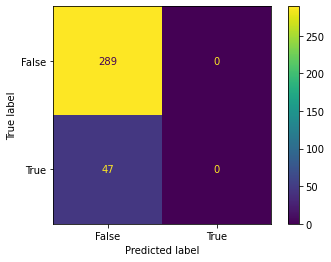

In [62]:
from sklearn import metrics

threshold = 0.45


output = model.predict(np.asarray(x_test).astype('float32'))

output[output[:,1] > threshold] = [0,1]


actual = np.argmax(y_val, axis=-1)
predicted = np.argmax(output, axis=-1)

incorrect = np.where(np.argmax(output,axis=-1) != np.argmax(y_val, axis=-1))
correct = np.where(np.argmax(output,axis=-1) == np.argmax(y_val, axis=-1))
print("Accuracy of predictions: ",round((np.size(correct) / (np.size(incorrect) + np.size(correct))) * 100,2))

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()


#### Using 'Unbalanced' data led to the network just predicting everything as 'False' which is basically worthless for our purposes

## USE BALANCED DATA NOW

****** With Normalization Layer *******
Residual True
Epoch 1/50
75/75 - 2s - loss: 0.7448 - false_negatives_4: 861.0000 - val_loss: 0.6873 - val_false_negatives_4: 137.0000 - 2s/epoch - 28ms/step
Epoch 2/50
75/75 - 0s - loss: 0.6192 - false_negatives_4: 811.0000 - val_loss: 0.4486 - val_false_negatives_4: 59.0000 - 216ms/epoch - 3ms/step
Epoch 3/50
75/75 - 0s - loss: 0.6153 - false_negatives_4: 806.0000 - val_loss: 0.6710 - val_false_negatives_4: 155.0000 - 219ms/epoch - 3ms/step
Epoch 4/50
75/75 - 0s - loss: 0.6150 - false_negatives_4: 811.0000 - val_loss: 0.5250 - val_false_negatives_4: 83.0000 - 227ms/epoch - 3ms/step
Epoch 5/50
75/75 - 0s - loss: 0.6110 - false_negatives_4: 796.0000 - val_loss: 0.6035 - val_false_negatives_4: 114.0000 - 233ms/epoch - 3ms/step
Epoch 6/50
75/75 - 0s - loss: 0.6006 - false_negatives_4: 777.0000 - val_loss: 0.5288 - val_false_negatives_4: 94.0000 - 249ms/epoch - 3ms/step
Epoch 7/50
75/75 - 0s - loss: 0.6053 - false_negatives_4: 784.0000 - val_loss: 0.

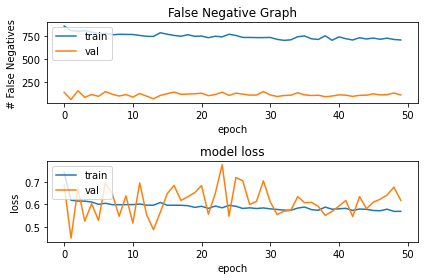

[0.6183924674987793, 109.0]


In [63]:


#x_train, x_val, y_train, y_val = train_test_split(x,y, test_size =0.2, random_state=42)

# set the paramters for the network
batch_size = 32
epochs = 50
n_hidden_units = 128
n_hidden_layers = 6

# engineer the learning rate so that it works with floats as randrange only works with ints
lr = .002

# way to one hot encode the target variable into categorical variables
y_bal_train = keras.utils.to_categorical(y_bal_train, len(np.unique(y)))
y_val = keras.utils.to_categorical(y_test, len(np.unique(y)))


# need to do [1:] to allow for dimensionality compatability
a = b = keras.layers.Input(shape = x_bal_train.shape[1:])

print('****** With Normalization Layer *******')
a = keras.layers.LayerNormalization(axis= -1)(a)

a = keras.layers.Flatten()(a)


print('Residual True')
a = keras.layers.Dense(n_hidden_units)(a)
for _ in range(n_hidden_layers):
    a_resid = a
    a = keras.layers.Dense(n_hidden_units, activation=keras.activations.relu)(a)
    a = keras.layers.Add()([a, a_resid])

# look at keras.activations options
# make sure to functionalize the layer object so we pass tensors
a = keras.layers.Dense(y_bal_train.shape[1], activation = keras.activations.softmax)(a)

# reset the model
model = keras.Model(b,a)

# Prep the model for -learning- 
### USE FALSE_NEGATIVES AS METRIC BECAUSE WE WANT TO MINIMIZE THIS METRIC
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True),
optimizer='adam',
metrics=[keras.metrics.FalseNegatives()])

# urn off print because we will look at the best model
history = model.fit(x_bal_train, y_bal_train,
    batch_size = batch_size,
    epochs = epochs,
    verbose = 2,
    validation_data = (x_test, y_val)
            )
# don't need to print out each evaluation
score = model.evaluate(x_test, y_val, verbose = 1)

plot_acc_loss(history)

print(score)

11/11 [==============================] - 0s 1ms/step
Accuracy of predictions:  65.77


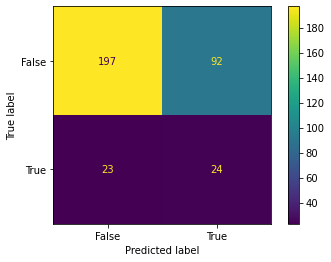

In [64]:
from sklearn import metrics

threshold = 0.45


output = model.predict(np.asarray(x_test).astype('float32'))

output[output[:,1] > threshold] = [0,1]


actual = np.argmax(y_val, axis=-1)
predicted = np.argmax(output, axis=-1)

incorrect = np.where(np.argmax(output,axis=-1) != np.argmax(y_val, axis=-1))
correct = np.where(np.argmax(output,axis=-1) == np.argmax(y_val, axis=-1))
print("Accuracy of predictions: ",round((np.size(correct) / (np.size(incorrect) + np.size(correct))) * 100,2))

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()



### Balancing the data greatly improved our metrics, but this type of network still vastly underperformed the log_r / xgboost models
- I will not be using neural network in my model comparison in my run.py script